<a href="https://colab.research.google.com/github/sha256burim/Implementation-of-TensorFlow-Fast-GAN-Neural-Style-Transfer/blob/main/Regression_DMD_XPRO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lets start with importing what we need... 

In [ ]:
!pip install skimpy

In [ ]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import norm
from skimpy import skim
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import datasets

Lets read in the data into a Pandas 'dataframe'. We'll see that this is a nifty datastruture. We'll take a look at the data frame shortly. 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/XPro/rentals_weather.csv')

NameError: ignored

In [ ]:
df.head(6)

,rentals,month,day,hour,day_of_week,weekend,temp,temp_wb,rel_humidity,windspeed,precipitation
0,4,1,1,0,Mon,0,2,0,59,16,0.0
1,6,1,1,1,Mon,0,1,0,59,11,0.0
2,6,1,1,2,Mon,0,1,-1,54,21,0.0
3,1,1,1,5,Mon,0,0,-2,54,18,0.0
4,3,1,1,6,Mon,0,0,-2,54,15,0.0
5,3,1,1,7,Mon,0,0,-2,54,11,0.0


In [ ]:
df.tail(6)

,rentals,month,day,hour,day_of_week,weekend,temp,temp_wb,rel_humidity,windspeed,precipitation
8597,69,12,31,18,Mon,0,42,37,60,10,0.00
8598,36,12,31,19,Mon,0,39,36,76,13,0.02
8599,25,12,31,20,Mon,0,38,36,86,14,0.04
8600,13,12,31,21,Mon,0,37,36,89,15,0.07
8601,6,12,31,22,Mon,0,38,37,89,14,0.09
8602,7,12,31,23,Mon,0,39,38,89,17,0.19


Looking at the data, its clear that things like 'day_of_week' or 'day' are not truly numerical (in the sense of a temperature or a price) but rather *categorical*. So we go ahead an declare those columns of the dataframe as such. 

In [ ]:
categorical_variables = ['month','day','hour','day_of_week','weekend']
df[categorical_variables] = df[categorical_variables].astype('category')

In [ ]:
skim(df)

╭───────────────────────────────────── skimpy summary ──────────────────────────────────────╮
│          Data Summary                Data Types               Categories                  │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓ ┏━━━━━━━━━━━━━━━━━━━━━━━┓          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃ ┃ Categorical Variables ┃          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩ ┡━━━━━━━━━━━━━━━━━━━━━━━┩          │
│ │ Number of rows    │ 8603   │ │ int64       │ 5     │ │ month                 │          │
│ │ Number of columns │ 11     │ │ category    │ 5     │ │ day                   │          │
│ └───────────────────┴────────┘ │ float64     │ 1     │ │ hour                  │          │
│                                └─────────────┴───────┘ │ day_of_week           │          │
│                                                        │ weekend               │          │
│                                                        └───────────────────────┘          │
│                                          number                                           │
│ ┏━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━┳━━━━━┳━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃             ┃ missing ┃ complete   ┃ mean   ┃ sd    ┃ p0 ┃ p25 ┃ p75 ┃ p100 ┃ hist   ┃  │
│ ┃             ┃         ┃ rate       ┃        ┃       ┃    ┃     ┃     ┃      ┃        ┃  │
│ ┡━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━╇━━━━━╇━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ rentals     │       0 │          1 │    210 │   230 │  1 │  32 │ 310 │ 1300 │  █▃▁   │  │
│ │ temp        │       0 │          1 │     53 │    18 │ -2 │  38 │  69 │   97 │  ▂█▆▇▂ │  │
│ │ temp_wb     │       0 │          1 │     48 │    17 │ -3 │  34 │  62 │   81 │  ▂█▇█▅ │  │
│ │ rel_humidit │       0 │          1 │     67 │    19 │ 16 │  53 │  84 │  100 │ ▁▃▇█▇▇ │  │
│ │ y           │         │            │        │       │    │     │     │      │        │  │
│ │ windspeed   │       0 │          1 │     11 │   5.5 │  0 │   7 │  14 │   48 │  ▄█▂   │  │
│ │ precipitati │       0 │          1 │ 0.0054 │ 0.034 │  0 │   0 │   0 │  1.1 │   █    │  │
│ │ on          │         │            │        │       │    │     │     │      │        │  │
│ └─────────────┴─────────┴────────────┴────────┴───────┴────┴─────┴─────┴──────┴────────┘  │
│                                         category                                          │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃                    ┃ missing      ┃ complete rate         ┃ ordered      ┃ unique    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ month              │            0 │                     1 │ False        │        12 │  │
│ │ day                │            0 │                     1 │ False        │        31 │  │
│ │ hour               │            0 │                     1 │ False        │        24 │  │
│ │ day_of_week        │            0 │                     1 │ False        │         7 │  │
│ │ weekend            │            0 │                     1 │ False        │         2 │  │
│ └────────────────────┴──────────────┴───────────────────────┴──────────────┴───────────┘  │
╰─────────────────────────────────────────── End ───────────────────────────────────────────╯

Lets produce a histogram of rentals data. We've selected bins based on what we saw of the data from the summary we gleaned using 'skim'.

Text(0, 0.5, 'Number of Data Points')

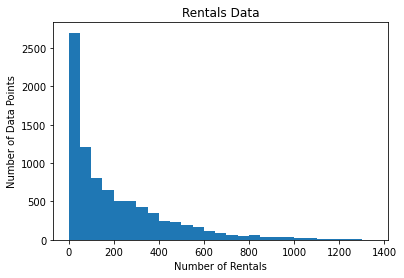

In [ ]:
plt.hist(df['rentals'], bins = range(0,1400,50))
plt.title('Rentals Data')
plt.xlabel('Number of Rentals')
plt.ylabel('Number of Data Points')

The mean number of rental is ~205, with a standard deviation of 227.

In [ ]:
print("Average no. of Rentals: "+str(np.mean(df['rentals']))+" Standard Dev: "+str(np.std(df['rentals'])))

Average no. of Rentals: 205.08578402882716 Standard Dev: 227.03926517480508


Next a histogram at a temp of 25F. 

Text(0, 0.5, 'Number of Data Points')

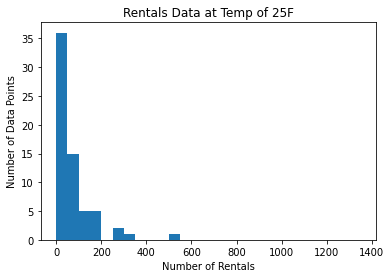

In [ ]:
df_cold = df[df['temp']==25]
plt.hist(df_cold['rentals'], bins = range(0,1400,50))
plt.title('Rentals Data at Temp of 25F')
plt.xlabel('Number of Rentals')
plt.ylabel('Number of Data Points')

Standard deviation is now a lot smaller..

In [ ]:
print("Average no. of Rentals at 25F: "+str(np.mean(df_cold['rentals']))+" Standard Dev: "+str(np.std(df_cold['rentals'])))

Average no. of Rentals at 25F: 72.55384615384615 Standard Dev: 90.4802623218041


A scatter plot of rentals across hour of rental shows that knowing the hour of rental could potentially reduce variability dramatically.

Text(0, 0.5, '# Rentals')

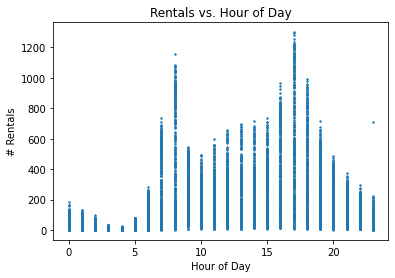

In [ ]:
plt.scatter(df['hour'],df['rentals'],s=2)
plt.title('Rentals vs. Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('# Rentals')

Now lets take a look at rentals vs. temperature. We also look at the mean (or average) number of rentals and notice a definite straight-line like trend

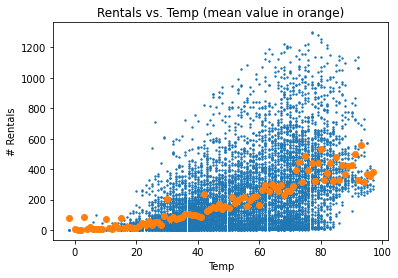

In [ ]:
plt.scatter(df['temp'],df['rentals'],s=2)
plt.title('Rentals vs. Temp (mean value in orange)')
plt.xlabel('Temp')
plt.ylabel('# Rentals')
plt.scatter(df['temp'].unique(),df.groupby('temp')['rentals'].mean())

The above scatter plot is the key motivation for linear regression which we will turn to next. In particular, we will run a number of regressions of the type 'rentals' vs. some other independent variable (eg. temp) that we belive to have explanatory power.  

In [ ]:
est = ols(formula="rentals ~ temp", data=df).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                rentals   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     2641.
Date:                Sun, 15 May 2022   Prob (F-statistic):               0.00
Time:                        19:17:29   Log-Likelihood:                -57727.
No. Observations:                8603   AIC:                         1.155e+05
Df Residuals:                    8601   BIC:                         1.155e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -115.1099      6.588    -17.473      0.0

In [ ]:
est = ols(formula="rentals ~ rel_humidity", data=df).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                rentals   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     249.5
Date:                Sun, 15 May 2022   Prob (F-statistic):           1.99e-55
Time:                        19:17:33   Log-Likelihood:                -58756.
No. Observations:                8603   AIC:                         1.175e+05
Df Residuals:                    8601   BIC:                         1.175e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      340.2762      8.892     38.266   

In [ ]:
est = ols(formula="rentals ~ weekend", data=df).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                rentals   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     132.1
Date:                Sun, 15 May 2022   Prob (F-statistic):           2.42e-30
Time:                        19:17:36   Log-Likelihood:                -58814.
No. Observations:                8603   AIC:                         1.176e+05
Df Residuals:                    8601   BIC:                         1.176e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      222.8186      2.878     77.417   

In [ ]:
est = ols(formula="rentals ~ day_of_week", data=df).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                rentals   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     25.13
Date:                Sun, 15 May 2022   Prob (F-statistic):           9.94e-30
Time:                        19:17:41   Log-Likelihood:                -58805.
No. Observations:                8603   AIC:                         1.176e+05
Df Residuals:                    8596   BIC:                         1.177e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            225.2480      6

As a first step with multiple linear regression, we look for correlations between our independent variables. The reason is simple enough -- if two distinct variables are highly correlated, we may not want to include both. The reason for this is that it causes something called 'collinearity' which we will examine more carefully a bit later.  

In [ ]:
df.corr()

,rentals,temp,temp_wb,rel_humidity,windspeed,precipitation
rentals,1.000000,0.484716,0.425792,-0.167903,-0.019345,-0.071619
temp,0.484716,1.000000,0.977801,0.126377,-0.148411,0.018469
temp_wb,0.425792,0.977801,1.000000,0.319822,-0.188347,0.057638
rel_humidity,-0.167903,0.126377,0.319822,1.000000,-0.218430,0.206801
windspeed,-0.019345,-0.148411,-0.188347,-0.218430,1.000000,0.069177
precipitation,-0.071619,0.018469,0.057638,0.206801,0.069177,1.000000


In [ ]:
est = ols(formula="rentals ~ temp + rel_humidity", data=df).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                rentals   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     1742.
Date:                Sun, 15 May 2022   Prob (F-statistic):               0.00
Time:                        19:17:52   Log-Likelihood:                -57416.
No. Observations:                8603   AIC:                         1.148e+05
Df Residuals:                    8600   BIC:                         1.149e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       52.9562      9.175      5.772   

What is the standard deviation of our residuals? Our best guess is the square root of the average squared residuals. 

In [ ]:
print(np.sqrt(est.mse_resid))

191.56676007313123


So if we decided to predict the number of rentals when the temp is 60F and the relative humidity is 50%, the *point* estimate is simply

In [ ]:
print('y_pred = 52.9562 + 6.3829*60 - 2.7942*50 = ' + str(52.9562 + 6.3829*60 - 2.7942*50))

y_pred = 52.9562 + 6.3829*60 - 2.7942*50 = 296.2202


So, a probabilistic estimate will be well modeled as a Normal random variable with mean 296.22 and standard deviation 191.63. We can now answer a question like 'What is the chance that the number of rentals exceeds 400 when the temp is 60F and the relative humidity is 50%?'. The answer: the same as the probability that a Normal random variable with mean 296.22 and standard deviation 191.63 exceeds 400!

In [ ]:
print('Probability of at least 400 rentals at 60F with 50% humidity: '+str(1-norm.cdf(400,loc=296.22,scale=191.63)))

Probability of at least 400 rentals at 60F with 50% humidity: 0.2940592857195723


In [ ]:
est.conf_int(alpha = 0.05)

,0,1
Intercept,34.971280,70.941053
temp,6.159768,6.606104
rel_humidity,-3.009922,-2.578540


In [ ]:
random_data = np.random.rand(len(df['rentals']))
df['random'] = random_data
df.head(6)

,rentals,month,day,hour,day_of_week,weekend,temp,temp_wb,rel_humidity,windspeed,precipitation,random
0,4,1,1,0,Mon,0,2,0,59,16,0.0,0.977220
1,6,1,1,1,Mon,0,1,0,59,11,0.0,0.191003
2,6,1,1,2,Mon,0,1,-1,54,21,0.0,0.849750
3,1,1,1,5,Mon,0,0,-2,54,18,0.0,0.734478
4,3,1,1,6,Mon,0,0,-2,54,15,0.0,0.966843
5,3,1,1,7,Mon,0,0,-2,54,11,0.0,0.128064


In [ ]:
df['rentals'].corr(df['random'])

-0.0061744359767808

Text(0, 0.5, '# Rentals')

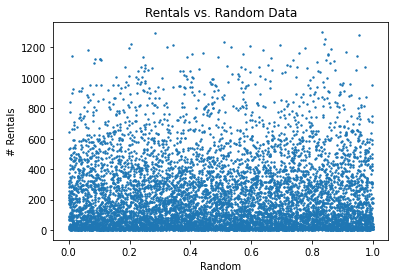

In [ ]:
plt.scatter(df['random'],df['rentals'],s=2)
plt.title('Rentals vs. Random Data')
plt.xlabel('Random')
plt.ylabel('# Rentals')

In [ ]:
est = ols(formula="rentals ~ temp + rel_humidity + random", data=df).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                rentals   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     1162.
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        15:07:12   Log-Likelihood:                -57416.
No. Observations:                8603   AIC:                         1.148e+05
Df Residuals:                    8599   BIC:                         1.149e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       56.9138      9.834      5.787   

In [ ]:
est = ols(formula="rentals ~ temp + rel_humidity + windspeed + precipitation", data=df).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                rentals   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     876.1
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        15:07:14   Log-Likelihood:                -57409.
No. Observations:                8603   AIC:                         1.148e+05
Df Residuals:                    8598   BIC:                         1.149e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        40.8156     11.488      3.553

In [ ]:
est = ols(formula="rentals ~ temp + rel_humidity + precipitation", data=df).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                rentals   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     1168.
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        15:07:16   Log-Likelihood:                -57410.
No. Observations:                8603   AIC:                         1.148e+05
Df Residuals:                    8599   BIC:                         1.149e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        48.6214      9.242      5.261

In [ ]:
est = ols(formula="rentals ~ temp + temp_wb", data=df).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                rentals   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     1738.
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        15:19:27   Log-Likelihood:                -57420.
No. Observations:                8603   AIC:                         1.148e+05
Df Residuals:                    8600   BIC:                         1.149e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -119.2405      6.359    -18.752      0.0

Let's split our data into a training set (70% of the data) and a test set (the remaining 30%). We will use the train_test_split utlity we imported to accomplish this. 

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.3)

Let's retrain a model on just the training data: 

In [ ]:
est_train = ols(formula="rentals ~ temp + rel_humidity + precipitation", data=df_train).fit()
print(est_train.summary())

                            OLS Regression Results                            
Dep. Variable:                rentals   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     811.9
Date:                Sun, 15 May 2022   Prob (F-statistic):               0.00
Time:                        20:02:55   Log-Likelihood:                -40130.
No. Observations:                6022   AIC:                         8.027e+04
Df Residuals:                    6018   BIC:                         8.030e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        43.2025     10.974      3.937

How well does it do on the test data? Lets use the model we learned on the training data to predict rentals on the test data and then measure the OOS R^2 

In [ ]:
test_pred = est_train.predict(df_test)
print('OOS R-squared: '+str(r2_score(df_test['rentals'],test_pred)))

OOS R-squared: 0.29117772833855426


### **Diabetes Dataset** 

Lets load the publicly available diabetes dataset and print out a description of the dataset

In [ ]:
diabetes = datasets.load_diabetes(as_frame=True)
diabetes_df = diabetes['frame']

In [ ]:
print(diabetes['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Your task is to build the best linear regression model you can using this data to predict the 'target' field. 

In [ ]:
diabetes_df.head(6)